# Exercise 07
## Lars Kühmichel, Nicolas Wolf

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pl
import scipy.stats as stats
import scipy.special as special
import scipy.optimize as optimize
import scipy.signal as signal

In [131]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

## Task 1: Poisson latent variable models

In [132]:
path = pl.Path("data/")
pattern = "*.csv"

params = {}

for file in path.glob(pattern):
    params[file.stem] = np.genfromtxt(str(file), delimiter=",")

# makes no sense to have data dimension on first axis
params["u"] = params["u"].T

params.keys()

dict_keys(['A', 'u', 'n0', 'B', 'mu0', 'Sigma', 'Gamma'])

### 1. Create a time series of latent states $z$ and observations $c$ from these parameters, and plot them.

In [133]:
T = 100
M = 2

noise = np.random.multivariate_normal(mean=params["mu0"], cov=params["Sigma"], size=T)

z = [noise[0]]

for t in range(1, T):
    zt = params["A"] @ z[t - 1] + params["B"] @ params["u"][t] + noise[t]
    z.append(zt)

z = np.array(z)

z.shape

(100, 2)

In [134]:
lambdas = []
c = []

for t in range(T):
    lam = np.exp(np.log(params["n0"]) + params["Gamma"] @ z[t])
    dt = 1
    lam = lam * dt

    ct = np.random.poisson(lam)
    c.append(ct)
    lambdas.append(lam)

c = np.array(c)
lambdas = np.array(lambdas)

c.shape

(100, 4)

<AxesSubplot:>

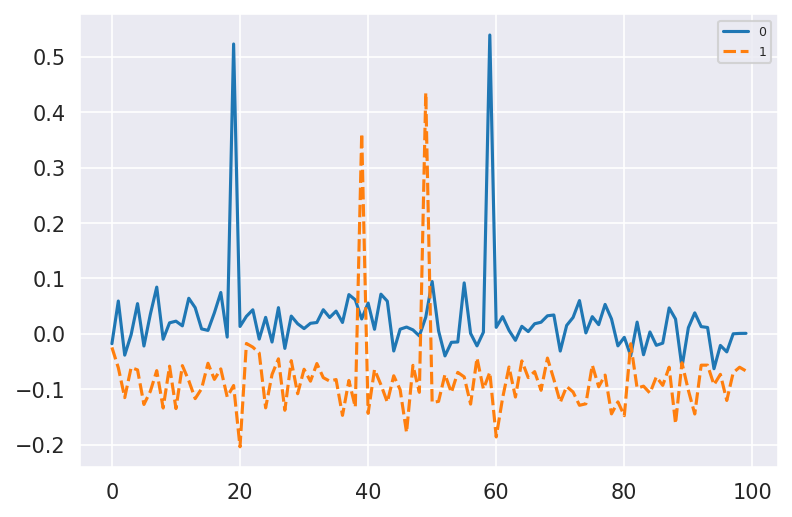

In [135]:
sns.lineplot(data=z)

<AxesSubplot:>

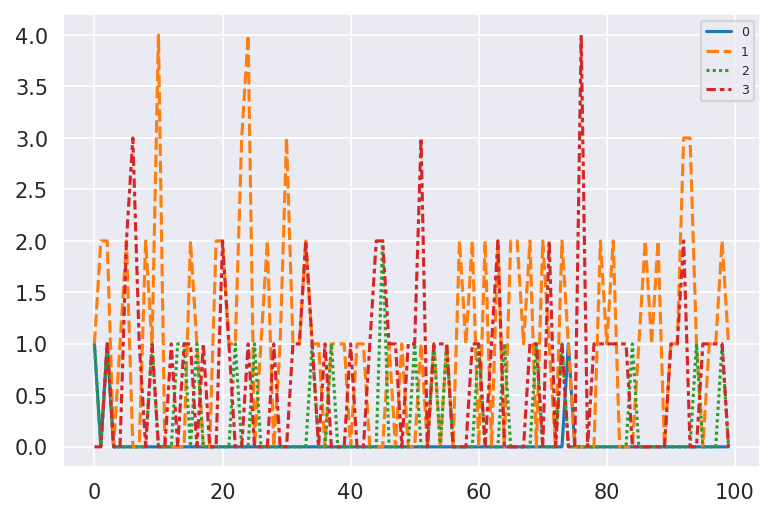

In [136]:
sns.lineplot(data=c)

<AxesSubplot:ylabel='Count'>

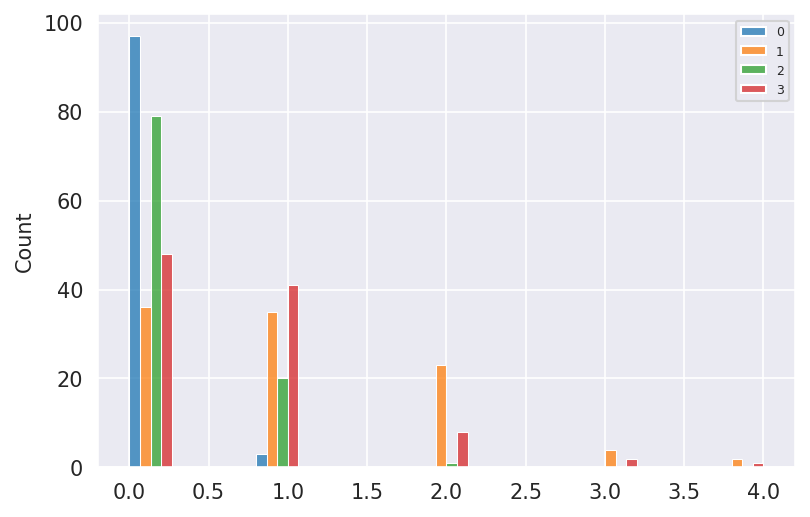

In [137]:
sns.histplot(data=c, multiple="dodge")

### 2. What is the joint data log-likelihood of your generated time series?

The likelihood factorizes:
$$
\mathcal{l}(\{ c_t z_t \} \vert \theta) = \mathcal{l}(c_t \vert z_t, \theta) + \mathcal{l}(z_t \vert \theta)
$$

We then have the Gaussian log-likelihood $\mathcal{l}(z_t \vert \theta)$ as the probability of the residuals, and the Poisson log-likelihood $\mathcal{l}(c_t \vert z_t, \theta)$, which we can compute from the random noise we generated earlier:

In [138]:
ll_gauss = stats.multivariate_normal.logpdf(noise, mean=params["mu0"], cov=params["Sigma"]).sum(axis=0)

ll_poisson = 0
for t in range(T):
    ll = stats.poisson.logpmf(c[t], mu=lambdas[t]).sum()
    ll_poisson += ll

log_likelihood = ll_gauss + ll_poisson

log_likelihood

100.82617172998778

## Task 2: Fixed points, stability and bifurcations

### 1. For the given parameters, find the fixed points of the system.

First, just look at the function to get initial guesses:

In [139]:
def f(x, w=7, theta=-2.5):
    return w * special.expit(x) + theta

Text(0, 0.5, '$x_{t+1}$')

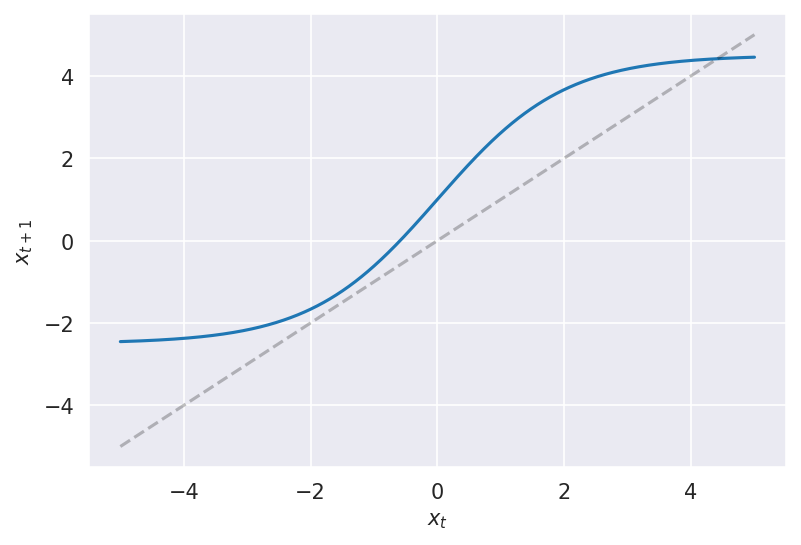

In [140]:
x = np.linspace(-5, 5, 1000)
y = f(x)

plt.plot(x, y)
plt.plot(x, x, ls="--", color="black", alpha=0.25)
plt.xlabel("$x_t$")
plt.ylabel("$x_{t+1}$")

We can see that while the function gets close at $x_t \sim -1.5$, the only root here is $x_t \sim 4$.

In [141]:
def get_fixed_points(f, xmin, xmax, args=()):
    fixed_points = []
    x0s = np.linspace(-xmin, xmax, 1000)

    for x0 in x0s:
        fp, info, ier, msg = optimize.fsolve(lambda x: f(x, *args) - x, x0=x0, full_output=True)
        if ier == 1:
            # found a solution
            fixed_points.append(fp)

    fixed_points = np.squeeze(fixed_points)

    fixed_points, mult = signal.unique_roots(fixed_points, tol=1e-2)

    return fixed_points

fixed_points = get_fixed_points(f, -10, 10)

print(f"Found {len(fixed_points)} fixed points.")
fixed_points[0:5]

Found 1 fixed points.


array([4.41647135])

### Visualize these in a graph.

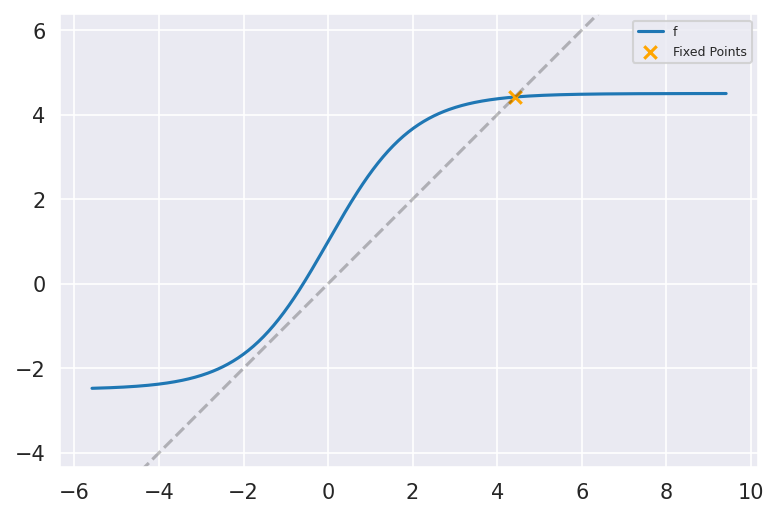

In [142]:
x = np.linspace(fixed_points.min() - 10, fixed_points.max() + 5, 500)
y = f(x)

plt.plot(x, y, label="f", zorder=1)
plt.scatter(fixed_points, f(fixed_points), marker="x", color="orange", label="Fixed Points", zorder=2)
plt.axis("equal")
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot(x, x, ls="--", color="black", alpha=0.25)
plt.legend()

### Are they stable?

The fixed point at $x \sim 4$ is stable, since the slope of the return map around the fixed point is smaller than $1$. This means that when given values around the fixed point, the series will converge back to the fixed point (as opposed to further away from it). The other fixed points may not necessarily be stable, since, given different parameters, they could have a slope greater than $1$.

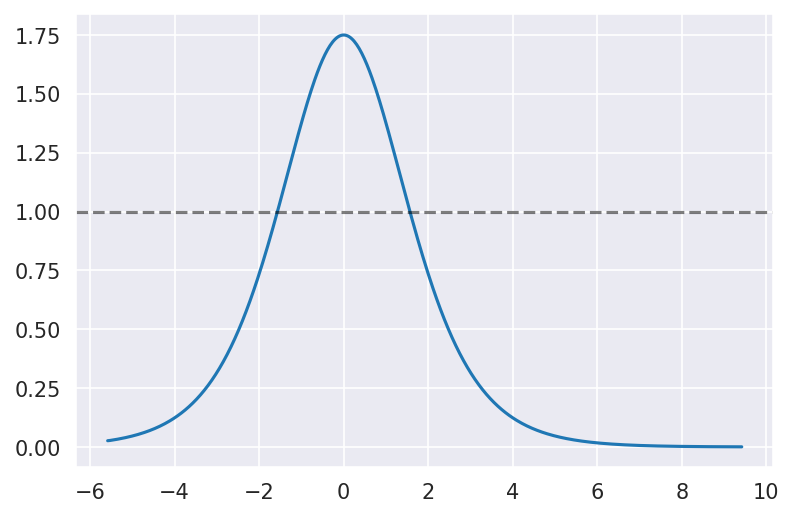

In [143]:
plt.plot(x, np.gradient(y, x))
plt.axhline(1, ls="--", color="black", alpha=0.5)

### 2. For $w = 7$, plot the bifurcation graph as a function of $\theta$.

In [144]:
from typing import Iterable

def flatten(iterable):
    for item in iterable:
        if isinstance(item, Iterable):
            yield from flatten(item)
            continue

        yield item

In [145]:
theta = np.linspace(-10, 10, 100)
w = 7
fixed_points = [get_fixed_points(f, -10, 10, args=(w, t,)) for t in theta]

In [146]:
mask = np.array([len(fp) > 0 for fp in fixed_points])
fixed_points = np.array(list(flatten(fixed_points)))
theta = theta[mask]

print(theta.shape, fixed_points.shape)

(88,) (88,)


Text(0, 0.5, 'Fixed Points')

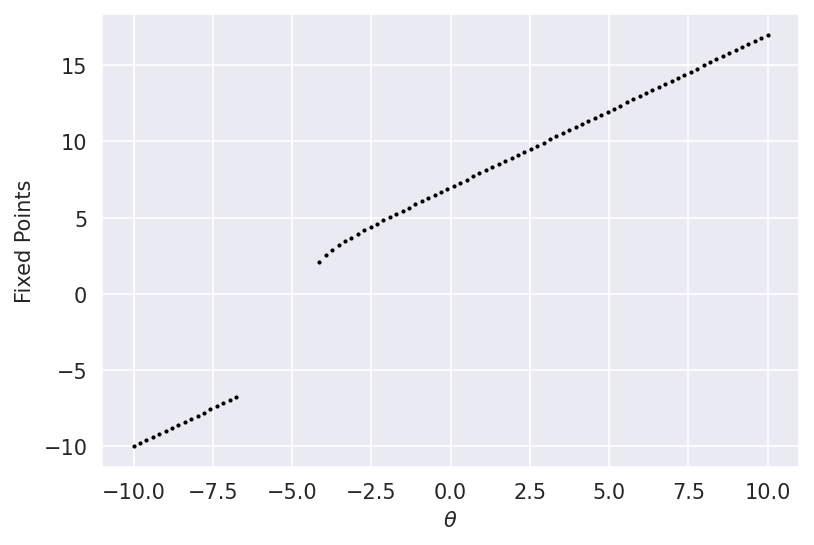

In [147]:
plt.scatter(theta, fixed_points, color="black", s=1)

plt.xlabel(r"$\theta$")
plt.ylabel("Fixed Points")